In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
import cv2


def build_mask_from_xml(filename):   
    tree = ET.parse(filename)
    root = tree.getroot()
    width=int(root.get('width'))
    height=int(root.get('height'))
    # Create a black image with the specified dimensions
    img = np.zeros((height, width, 3), np.uint8)
    # all items data
    for region in root.iter('FreeHand'):
        lista=[]
        if region.get('VISIBLE') == '1':
            for point in region:
                x=int(point.get('x'))
                y=int(point.get('y'))
                lista.append([x,y])
                # Define an array of points
            points=np.array(lista)
            cv2.fillPoly(img, pts=[points], color=(255, 255, 255))
    return img

gonada_x = np.array(Image.open("gonada.ppm"))
kidney_x = np.array(Image.open("kidney.ppm"))

gonada_y = np.array(Image.open("gonada gt.jpg"))
kidney_y = np.array(Image.open("kidney gt.jpg"))

In [ ]:



def kmeans_seg(img):
    img_float = np.float32(img)
    f_num = img.shape[-1]
    data = img_float.reshape((-1,f_num))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_PP_CENTERS
    _, labels, _ = cv2.kmeans(data, 2, None, criteria, 10, flags)

    output = labels.reshape((img.shape[0], img.shape[1]))
    binary_output = np.where(output == np.min(output), 0, 255).astype(np.uint8)
    return binary_output

gonada_seg = kmeans_seg(gonada_x)
kidney_seg = kmeans_seg(kidney_x)




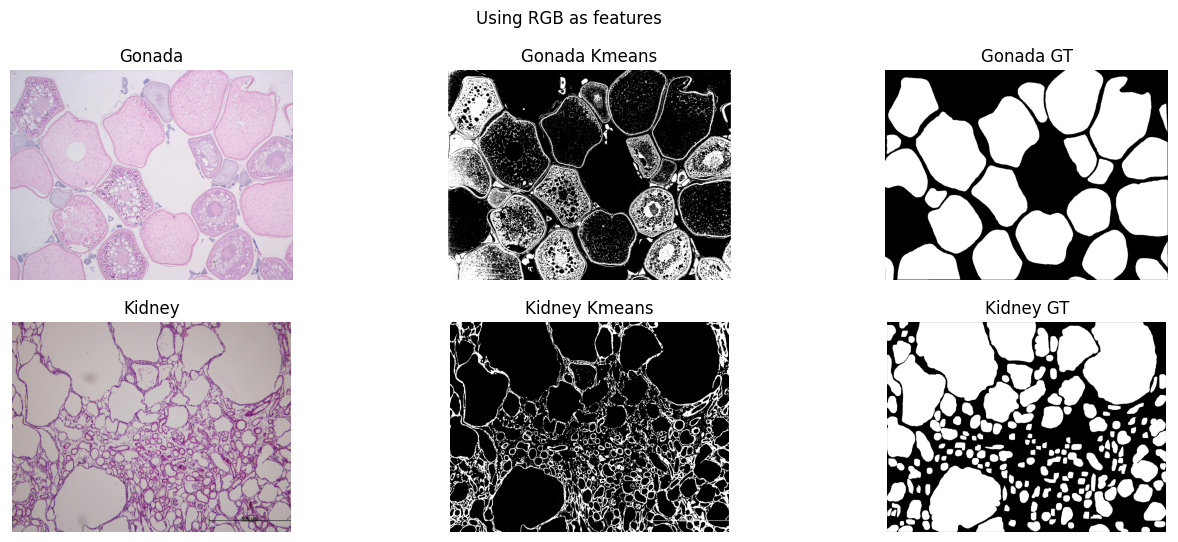

In [4]:
def plt_test_seg(x_list, y_list, seg_list, title_list, overall_title):
    count = len(x_list)
    fig ,axis = plt.subplots(count,3,figsize = (16,3*count))
    for i, (x, y, seg,title) in enumerate(zip(x_list,y_list,seg_list, title_list)):
        axis[i,0].imshow(x)
        axis[i,0].set_title(f'{title}')
        axis[i,0].axis('off')
        axis[i,1].imshow(seg, cmap = 'gray')
        axis[i,1].set_title(f'{title} Kmeans')
        axis[i,1].axis('off')
        axis[i,2].imshow(y, cmap = 'gray')
        axis[i,2].set_title(f'{title} GT')
        axis[i,2].axis('off')
    fig.suptitle(overall_title)

plt_test_seg(
    [gonada_x,kidney_x],
    [gonada_y,kidney_y],
    [gonada_seg,kidney_seg],
    ['Gonada','Kidney'],
    'Using RGB as features'
)

### Image features for clustering

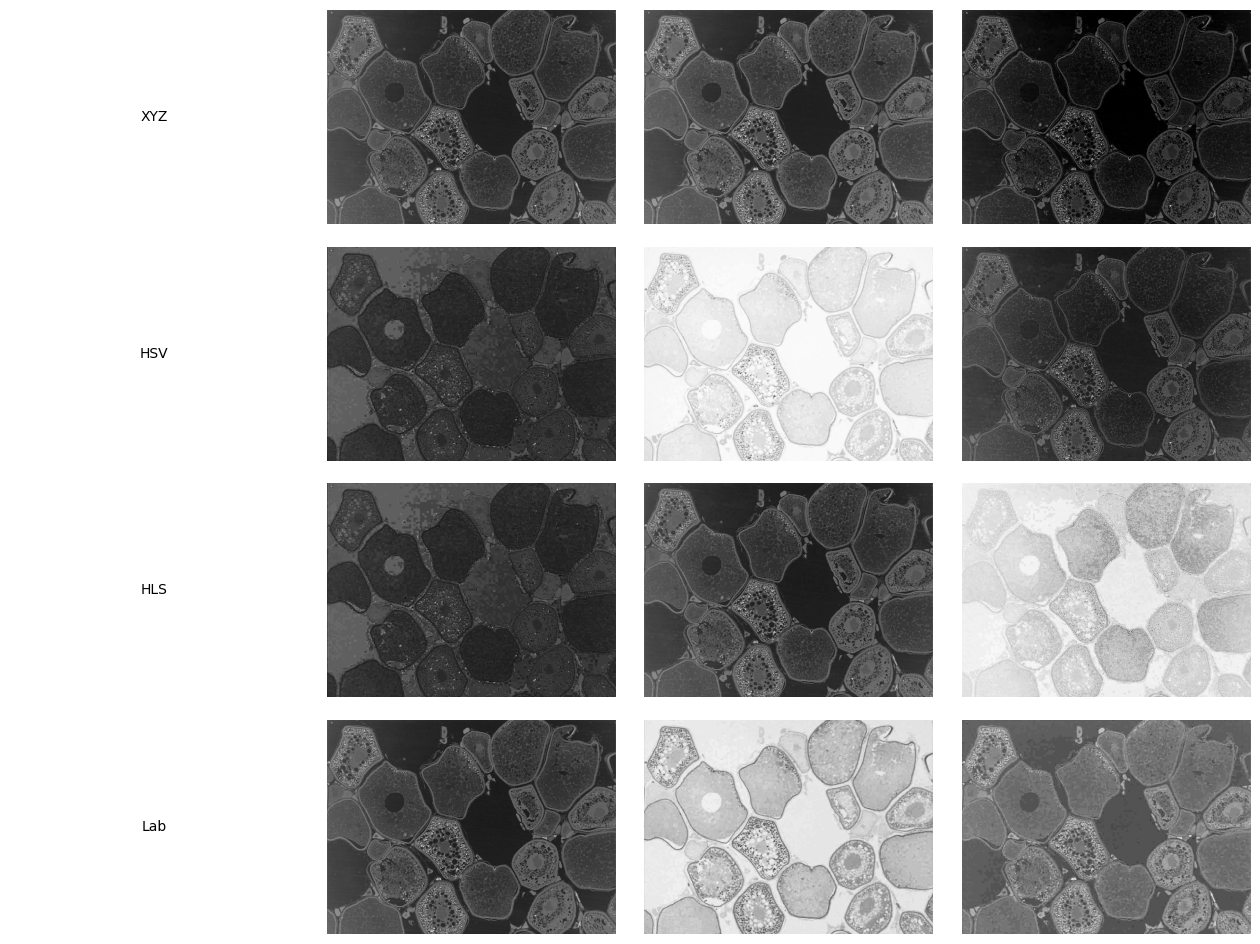

In [5]:
def plot_color_space(cvt_img: np.ndarray, axis, row, title):
    axis[row, 0].axis('off')
    axis[row, 0].text(0.5 , 0.5 , title,
        horizontalalignment='center',
        verticalalignment='center')
    for i in range(cvt_img.shape[2]):
        axis[row, i + 1].axis('off')
        axis[row, i + 1].imshow(cvt_img[:, :, i], cmap='Greys')


def plot_several_color_spaces(img, color_space_list, titles):
    cvt_img_list = [cv2.cvtColor(img, color_space)
                    for color_space in color_space_list]
    h = len(color_space_list)
    w = max([cvt_img.shape[2] for cvt_img in cvt_img_list])
    figure, axis = plt.subplots(h, w + 1, figsize=(16, h*3))
    figure.subplots_adjust(wspace= 0.1, hspace= 0.1)
    for row, (cvt_img, title) in enumerate(zip(cvt_img_list, titles)):
        plot_color_space(cvt_img, axis, row, title)
    plt.show


plot_several_color_spaces(gonada_x, [
    cv2.COLOR_RGB2XYZ,
    cv2.COLOR_RGB2HSV,
    cv2.COLOR_RGB2HLS,
    cv2.COLOR_RGB2Lab],
    ['XYZ',
     'HSV',
     'HLS',
     'Lab'])

In [6]:
xyz = cv2.cvtColor(gonada_x, cv2.COLOR_RGB2XYZ)
xyz_seg = kmeans_seg(xyz)

In [7]:
hsv = cv2.cvtColor(gonada_x, cv2.COLOR_RGB2HSV)
hsv_seg = kmeans_seg(hsv)

In [8]:
hls = cv2.cvtColor(gonada_x, cv2.COLOR_RGB2HLS)
hls_seg = kmeans_seg(hls)

In [9]:
lab = cv2.cvtColor(gonada_x, cv2.COLOR_RGB2Lab)
lab_seg = kmeans_seg(lab)

In [10]:
def plot_row(image_list,title_list):
    fig, axis = plt.subplots(1,len(image_list),figsize = (16,8))
    fig.subplots_adjust(wspace= 0.1)
    for i, (image, title) in enumerate(zip(image_list,title_list)):
        axis[i].imshow(image, cmap = 'gray')
        axis[i].axis('off')
        axis[i].set_title(title)

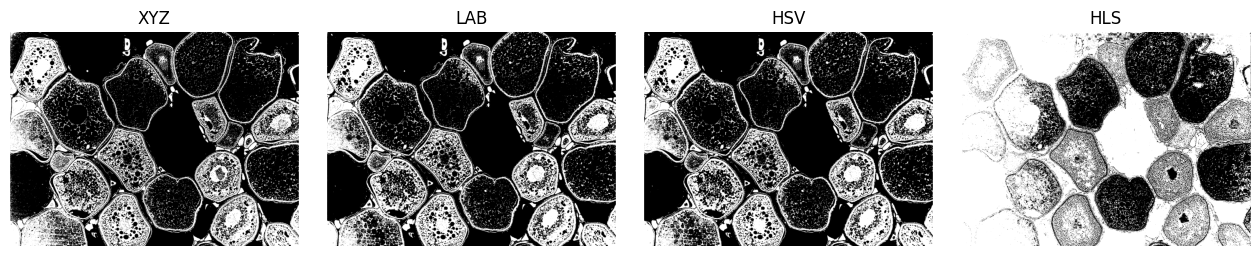

In [11]:
plot_row([xyz_seg, lab_seg, hsv_seg, hls_seg], 
         ['XYZ', 'LAB', 'HSV', 'HLS'])

### Best Feature Selection

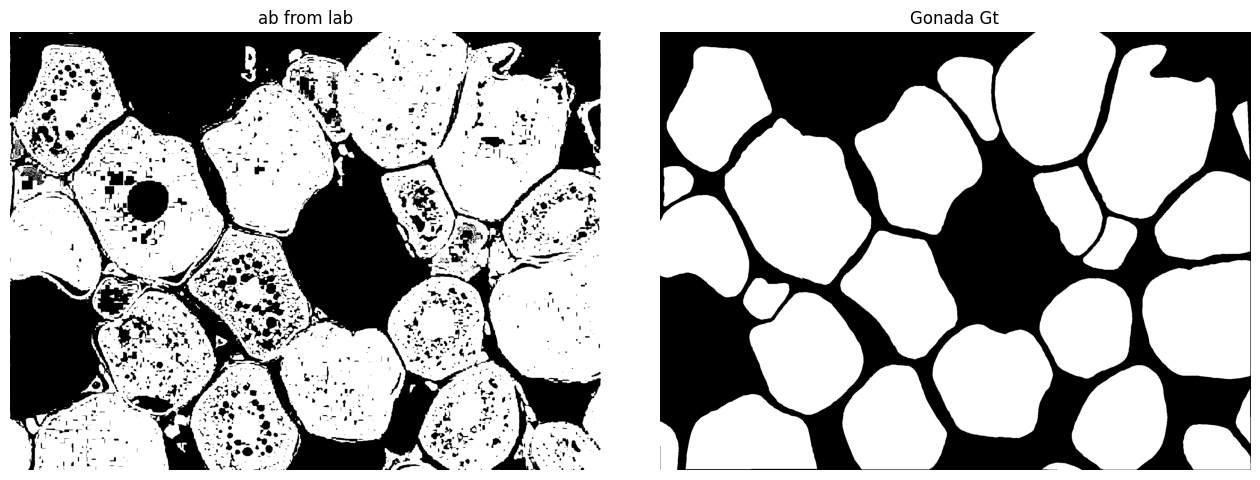

In [12]:
l, a, b = cv2.split(lab)

h, l_hls, s = cv2.split(hls)

ab = np.dstack((a, b))
ab_seg = kmeans_seg(ab)

plot_row([ab_seg, gonada_y], ['ab from lab', 'Gonada Gt'])


### Testing Closing the segmentation

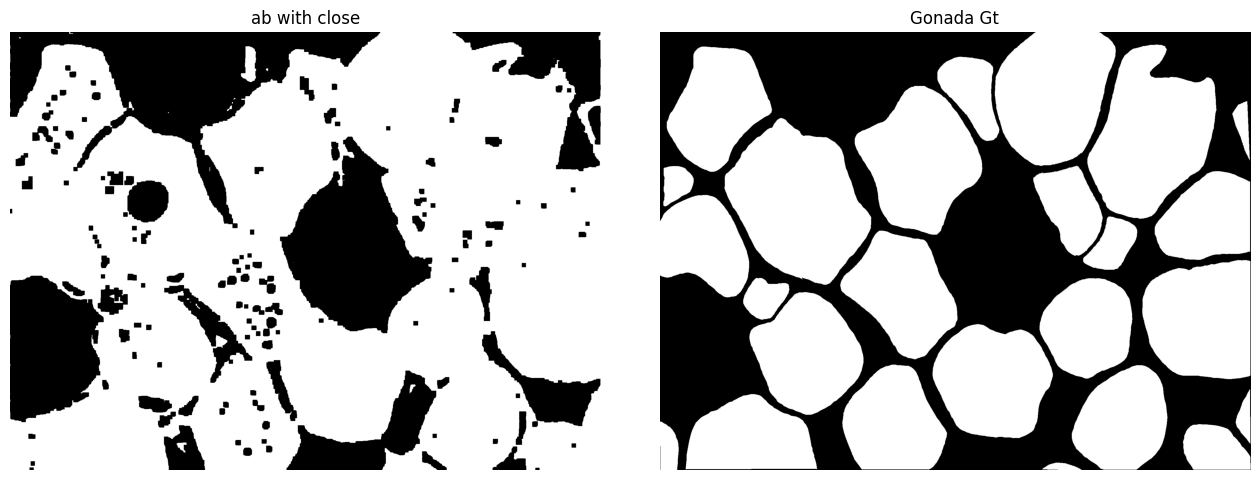

In [13]:
k = np.ones((15,15))
ab_withclose = cv2.morphologyEx(ab_seg,cv2.MORPH_CLOSE,k)

plot_row([ab_withclose, gonada_y], ['ab with close', 'Gonada Gt'])

### Testing Blurring the Image

(1550, 2088, 2)


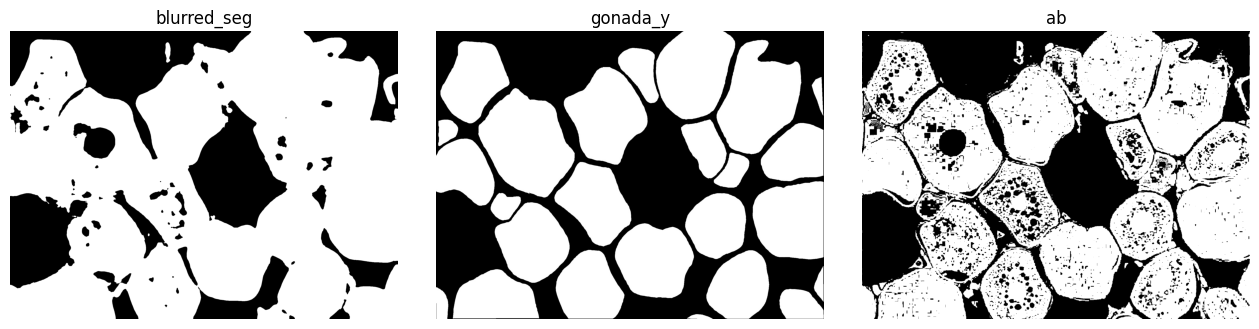

In [33]:
a_blurred = cv2.blur(a,(40,40))
b_blurred = cv2.blur(b,(40,40))

blurred_ab = np.stack([a_blurred,b_blurred], axis = -1)
print(blurred_ab.shape)
blurred_seg = kmeans_seg(blurred_ab)
plot_row([blurred_seg,gonada_y,ab_seg], ['blurred_seg','gonada_y', 'ab'])

### Testing Otsu initialization

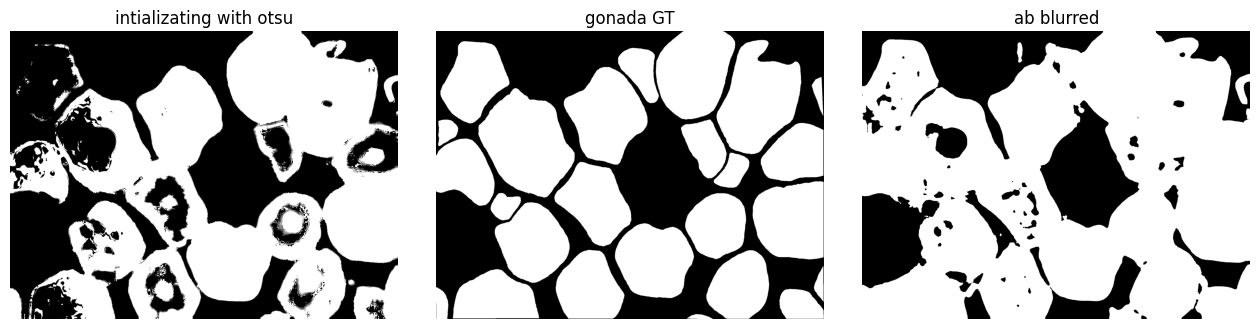

In [34]:
def kmeans_with_thres_init(img):
    img_float = np.float32(img)
    f_num = img.shape[-1]
    data = img_float.reshape((-1,f_num))
    gray = np.mean(img, axis=-1).astype(np.uint8)
    _ , clusters =  cv2.threshold(gray.reshape(1, gray.size),0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # _ , clusters =  cv2.threshold(gray.reshape(1, gray.size),np.mean(gray),1,cv2.THRESH_BINARY)
    flags = cv2.KMEANS_USE_INITIAL_LABELS
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _,labels,_ = cv2.kmeans(data,2,np.int32(clusters),criteria,10,flags)
    labels = np.int8(labels)
    output = labels.reshape((img.shape[0], img.shape[1]))
    binary_output = np.where(output == np.min(output), 0, 255).astype(np.uint8)
    return binary_output

thresh_seg = kmeans_with_thres_init(blurred_ab)
plot_row([thresh_seg,gonada_y,blurred_seg], ['intializating with otsu','gonada GT', 'ab blurred'])

### Statistical analysis of the segmentation using clustering

In [82]:
from pathlib import Path

x_path = Path("..\\dataset\\sterappimagesdb\\EuropeanHake\\EuropeanHake\\images").rglob('*.ppm')
x_path = [str(path) for path in x_path]

y_path = Path("..\\dataset\\sterappimagesdb\\EuropeanHake\\EuropeanHake\\xml").rglob('*.xml')
y_path = [str(path) for path in y_path]

x_path.sort()
y_path.sort()
print(len(x_path))
print(len(y_path))

47
47


In [ ]:
x = []
y = []

for path in x_path:
    x.append(np.array(Image.open(path)))   

for path in y_path:
    y.append(build_mask_from_xml(path))


In [86]:
x = x[4:]
y = y[4:]

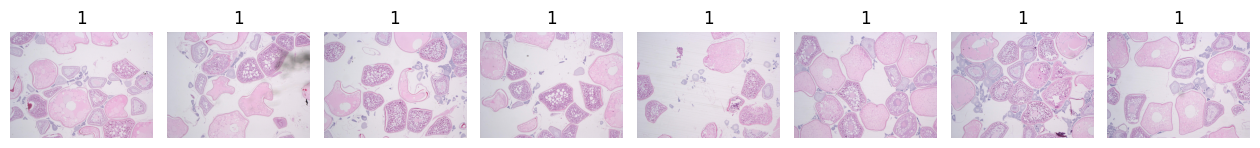

In [87]:
i = 0
plot_row(x[i:8 + i], [1]*8)

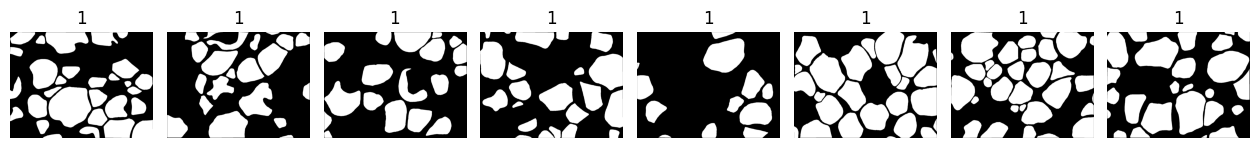

In [88]:
plot_row(y[i:8 + i], [1]*8)

In [94]:
f_rgb = x
f_lab = [cv2.cvtColor(img, cv2.COLOR_RGB2LAB) for img in x]
f_ab = []
for img in f_lab:
    l, a, b = cv2.split(img)
    f_ab.append(np.dstack([a,b]))

f_ab_blurred = []
for img in f_lab:
    l, a, b = cv2.split(img)
    a_blurred = cv2.blur(a,(40,40))
    b_blurred = cv2.blur(b,(40,40))
    f_ab_blurred.append(np.dstack([a_blurred, b_blurred]))